In [19]:
use_most_recent = True
custom_filepath = "../data/csvfiles/text_added"
n_topics = 10
lang_model = "en_core_web_trf"

In [20]:
import nltk, gensim, spacy
nltk.download("stopwords")
import warnings
import re
import glob, os
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import wordpunct_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.metrics import ConfusionMatrix
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.colors as mcolors

[nltk_data] Downloading package stopwords to /home/tflora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Get stopwords for Porguese and add prominent missing stopword ("to be")
# Full list of stopwords printed in appendix
pt_stopwords = nltk.corpus.stopwords.words('portuguese')
en_stopwords = nltk.corpus.stopwords.words('english')
html_elements = ['li', 'ul']
pt_stopwords.append("ser")
nltk_stopwords = pt_stopwords + en_stopwords + html_elements

In [22]:
if use_most_recent:
    try:
        filename = max(glob.iglob(f"../data/csvfiles/text_added/*.csv"), key = os.path.getmtime)
        df = pd.read_csv(filename)
    except ValueError:
        df = pd.read_csv(custom_filepath)
else:
    df = pd.read_csv(custom_filepath)
docs_raw = df['text'].astype(str)

In [23]:
X = df['text'].astype(str)
# Not immediately useful for unsupervised learning, but for planned
# supervised-learning extensions
y = df['topic']

In [24]:
# Remove escaped characters and single quotes
data = X.values.tolist()
data = [re.sub(r'\s+', ' ', t) for t in data]
data = [re.sub(r"\'", "", t) for t in data]

In [25]:
def text_to_words(article):
    for sentence in article:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = list(text_to_words(data))
# print(data[:1])
words = data

In [26]:
def lemmatization(data, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    data_lemmatized = []
    for sent in data:
        doc = nlp(" ".join(sent)) 
        data_lemmatized.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return data_lemmatized

In [28]:
# Initialize the pre-trained spacy language model
nlp = spacy.load(lang_model, disable=['parser', 'ner'])

# Perform lemmatization keeping nouns, adjectives, verbs, and adverbs
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'VERB']) #select noun and verb

In [29]:
from string import punctuation
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()
eng_stopwords = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\s+', gaps=True)
stemmer = PorterStemmer()
translate_tab = {ord(p): u" " for p in punctuation}

def text2tokens(raw_text):
    """Split the raw_text string into a list of stemmed tokens."""
    clean_text = raw_text.lower().translate(translate_tab)
    tokens = [token.strip() for token in tokenizer.tokenize(clean_text)]
    tokens = [token for token in tokens if token not in eng_stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return [token for token in stemmed_tokens if len(token) > 2]  # skip short tokens

dataset = [text2tokens(txt) for txt in newsgroups['data']]  # convert a documents to list of tokens

from gensim.corpora import Dictionary
dictionary = Dictionary(documents=dataset, prune_at=None)
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n=None)  # use Dictionary to remove un-relevant tokens
dictionary.compactify()

d2b_dataset = [dictionary.doc2bow(doc) for doc in dataset]  # convert list of tokens to bag of word representation

In [30]:
tokenized_data = [d.split() for d in data_lemmatized]

In [31]:
from gensim.corpora import Dictionary
dictionary = Dictionary(documents = tokenized_data, prune_at = None)
dictionary.filter_extremes(no_below = 2, no_above = 0.3, keep_n = None)
dictionary.compactify()

# Convert lemmatized tokens to BoW
bow_data = [dictionary.doc2bow(article) for article in tokenized_data]

In [32]:
from gensim.models import LdaMulticore
from gensim.models import TfidfModel

tfidf_model = TfidfModel(bow_data)
print(tfidf_model)

p1 = 10
p2 = 20

lda1 = LdaMulticore(corpus = bow_data,\
                    num_topics = n_topics,\
                    passes = p1)
lda2 = LdaMulticore(corpus = bow_data,\
                    num_topics = n_topics,\
                    passes = p2)

TfidfModel(num_docs=3084, num_nnz=161021)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

In [33]:
def plot_diff_plt(mdiff, title = f"LDA model topic correlations", annotation = None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title, fontsize = 16)
    plt.colorbar(data)

def plot_diff(mdiff, title="", annotation=None):
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

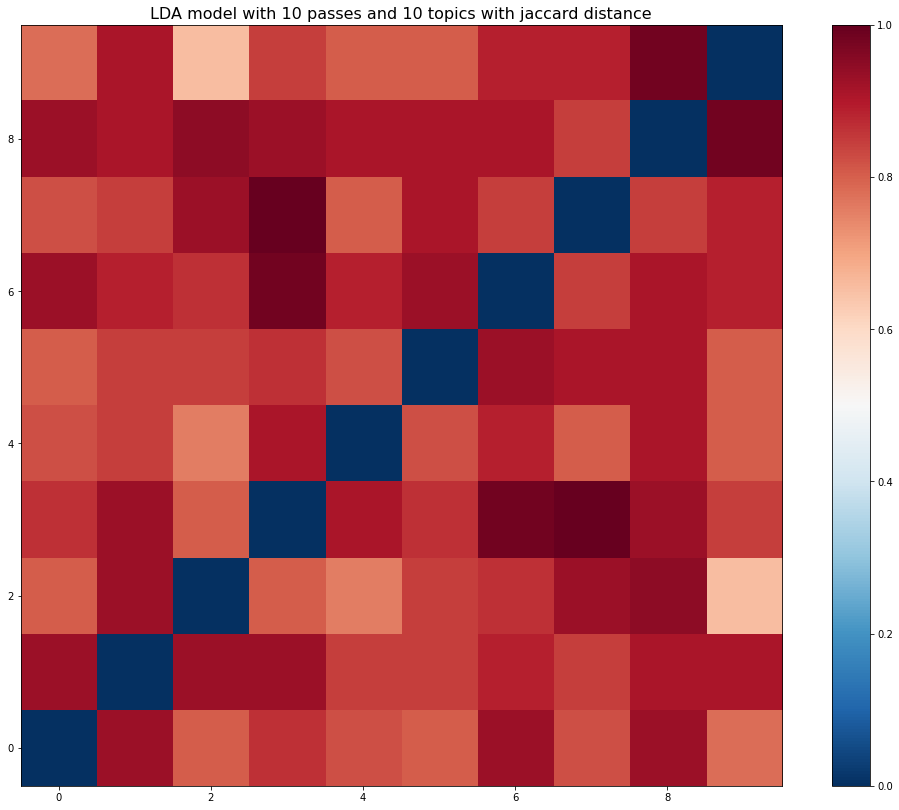

In [34]:
jac = "jaccard"
mj_diff, a = lda1.diff(lda1, distance=jac, num_words = 50)
plot_diff_plt(mj_diff, title = f"LDA model with {p1} passes and {n_topics} topics with {jac} distance", annotation = a)

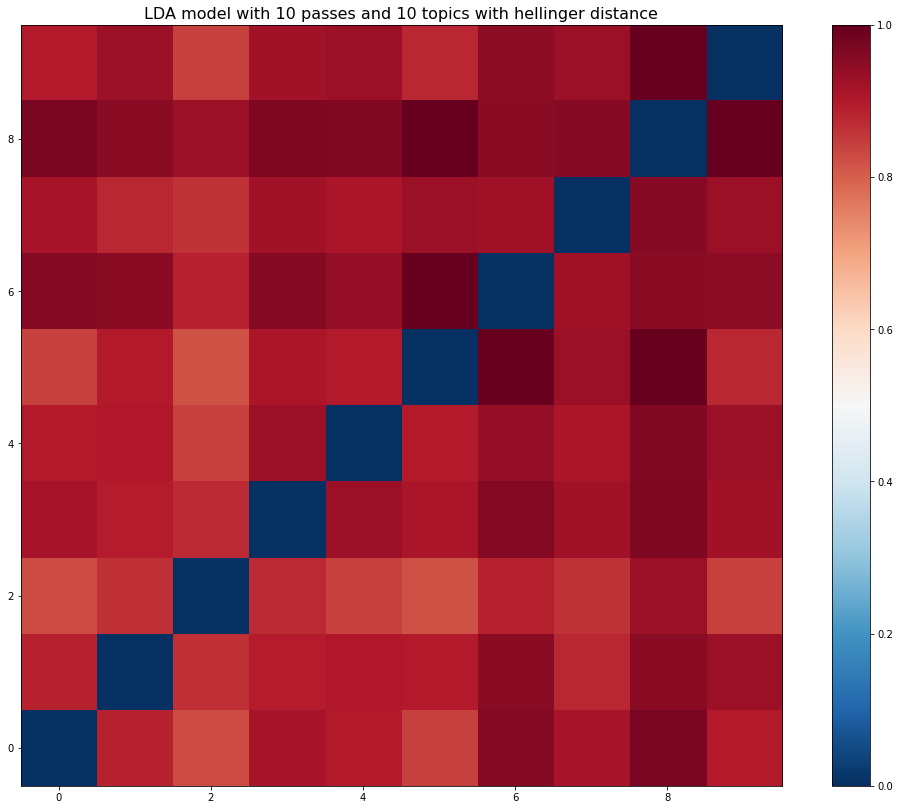

In [35]:
hel = "hellinger"
mh_diff, _ = lda1.diff(lda1, distance=hel, num_words = 50)
plot_diff_plt(mh_diff, title = f"LDA model with {p1} passes and {n_topics} topics with {hel} distance")

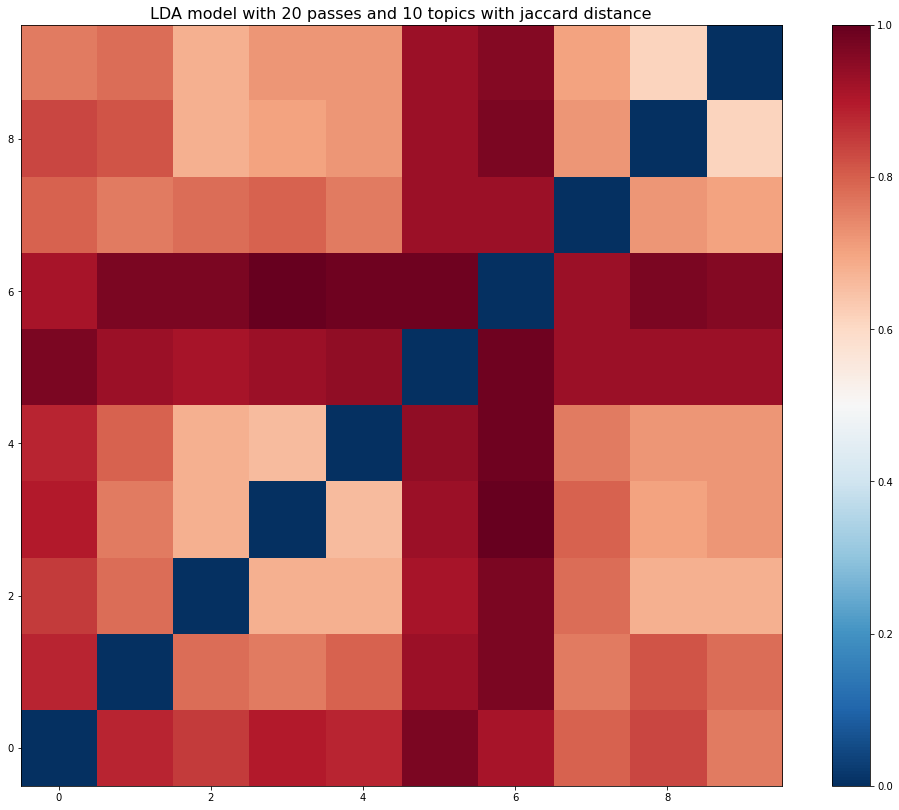

In [36]:
mj_diff, _ = lda2.diff(lda2, distance=jac, num_words = 50)
plot_diff_plt(mj_diff, title = f"LDA model with {p2} passes and {n_topics} topics with {jac} distance")

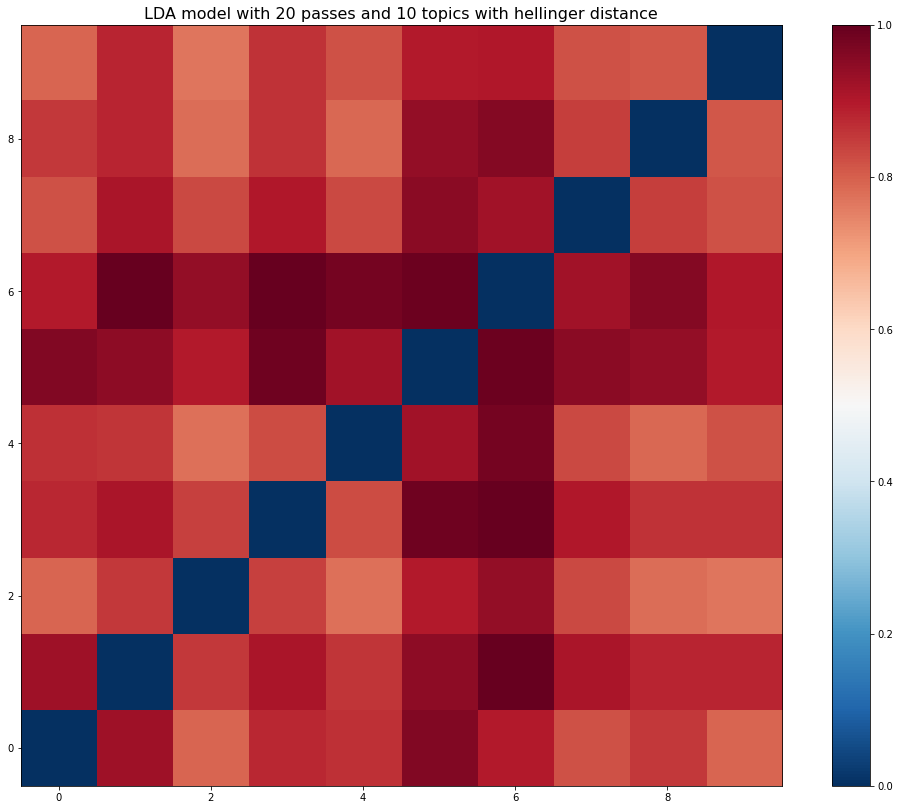

In [37]:
mh_diff, _ = lda2.diff(lda2, distance=hel, num_words = 50)
plot_diff_plt(mh_diff, title = f"LDA model with {p2} passes and {n_topics} topics with {hel} distance")

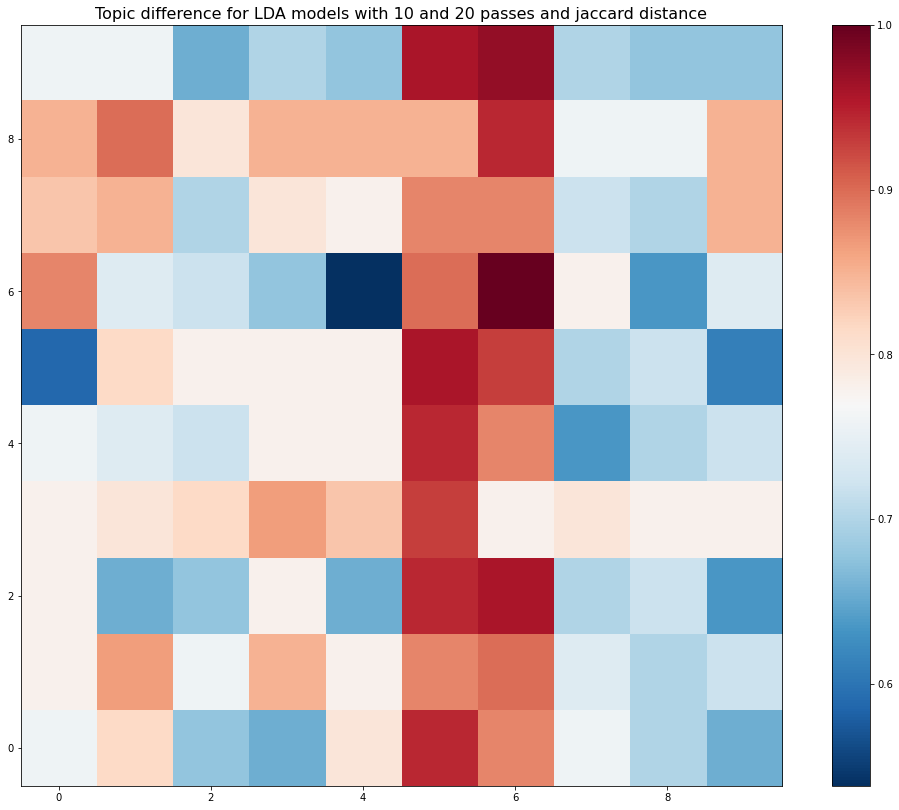

In [38]:
mdiff, _ = lda1.diff(lda2, distance=jac, num_words=50)
plot_diff_plt(mdiff, title=f"Topic difference for LDA models with {p1} and {p2} passes and {jac} distance")

In [39]:
# tf_vectorizer = CountVectorizer()
# dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                stop_words = nltk_stopwords,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

In [49]:
import pyLDAvis
p = pyLDAvis.gensim_models.prepare(lda1, bow_data, dictionary)
pyLDAvis.save_html(p, 'vis/lda1.html')

p2 = pyLDAvis.gensim_models.prepare(lda2, bow_data, dictionary)
pyLDAvis.save_html(p, 'vis/lda2.html')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/tflora/projects/capstone-project/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/tflora/projects/capstone-project/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/tflora/projects/capstone-project/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/tflora/projects/capstone-project/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/tf